<a href="https://colab.research.google.com/github/AmanPriyanshu/Reinforcement-Learning/blob/master/DQN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [12]:
torch.manual_seed(0)
np.random.seed(0)

In [13]:
class Environment:
  def __init__(self):
    self.constant_function_details = {'value':np.random.randint(10, 90)}
    self.uniform_function_details = {'min': 25, 'max': 75}
    self.gaussian_function_details = {'mean': 50, 'std': 25}
    self.quadratic_growth_details = {'m':0.0175, 'count':0}
    self.bandits = None
    self.generate_bandit_instance()

  def return_constant(self):
    return self.constant_function_details['value'] + np.random.random()*10

  def return_uniform(self):
    return np.random.uniform(self.uniform_function_details['min'], self.uniform_function_details['max'])

  def return_gaussian(self):
    return np.random.normal(loc=self.gaussian_function_details['mean'], scale=self.gaussian_function_details['std'])

  def return_quadratic_growth(self):
    self.quadratic_growth_details['count'] += 1
    return np.power((self.quadratic_growth_details['m'] * self.quadratic_growth_details['count']), 2)

  def generate_bandit_instance(self):
    self.bandits = np.array([self.return_constant, self.return_uniform, self.return_gaussian, self.return_quadratic_growth])
    np.random.shuffle(self.bandits)

  def observe_all_bandits(self):
    vals = []
    for func in self.bandits:
      vals.append(func()/100)
    return np.array(vals)

In [14]:
env = Environment()

In [15]:
values = []
for _ in range(1000):
  values.append(env.observe_all_bandits())

values = np.array(values)

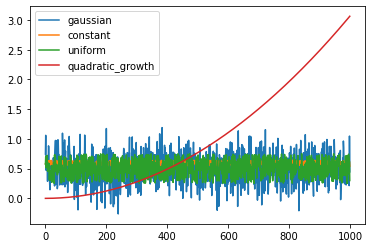

In [16]:
for index, function in enumerate(env.bandits):
  plt.plot(np.arange(values.shape[0]), values.T[index], label=function.__name__[len('return_'):])

plt.legend()
plt.show()

## Model:

In [17]:
def model_generator():
  model = torch.nn.Sequential(
          torch.nn.Linear(2, 4),
          torch.nn.ReLU(),
          torch.nn.Linear(4, 8),
          torch.nn.ReLU(),
          torch.nn.Linear(8, 4),
          torch.nn.Softmax(dim=1),
        )
  return model

In [18]:
class Agent:
  def __init__(self):
    self.transition = {'state': None, 'action': None, 'next_state': None, 'reward': None}
    self.replay_memory = self.ReplayMemory()
    self.policy_net = model_generator()
    self.target_net = model_generator()
    self.target_net.eval()
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.epsilon = 1
    self.epsilon_limit = 0.01
    self.steps_taken = 0
    self.gamma = 0.
    self.optimizer = torch.optim.Adam(self.policy_net.parameters())
    self.batch_size = 5

  def loss_calculator(self):
    samples = self.replay_memory.sample(self.batch_size)
    losses = []
    for sample in samples:
      action = sample['action']
      state = sample['state']
      next_state = sample['next_state']
      reward = sample['reward']

      loss = self.policy_pass(state)[0][action] - (reward + self.gamma * torch.max(self.target_pass(next_state)))
      losses.append(loss)
    
    loss = torch.mean(torch.stack(losses))
    
    if abs(loss.item()) < 1:
      loss = 0.5 * torch.pow(loss, 2)
    else:
      loss = torch.abs(loss) - 0.5

    return loss

  def policy_update(self):
    loss = self.loss_calculator()
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def target_update(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())

  def target_pass(self, state):
    input_state = torch.tensor([[state['rank'], state['reward']]], dtype=torch.float)
    actions = self.target_net(input_state)
    return actions

  def policy_pass(self, state):
    input_state = torch.tensor([[state['rank'], state['reward']]], dtype=torch.float)
    actions = self.policy_net(input_state)
    return actions
  
  def take_action(self, state):
    if np.random.random() < self.epsilon:
      action = torch.randint(0, 4, (1,))
    else:
      actions = self.policy_pass(state)
      action = torch.argmax(actions, 1)
    return action

  def take_transition(self, transition):
    self.steps_taken += 1
    self.replay_memory.push(transition)

    if self.steps_taken%self.batch_size == 0 and self.steps_taken>20:
      self.policy_update()
    if self.steps_taken%25 == 0 and self.steps_taken>20:
      self.target_update()

    self.epsilon -= self.epsilon_limit/6
    if self.epsilon<self.epsilon_limit:
      self.epsilon = self.epsilon_limit

  class ReplayMemory(object):
    def __init__(self, capacity=15):
      self.capacity = capacity
      self.memory = [None] * self.capacity
      self.position = 0

    def push(self, transition):
      self.memory[self.position] = transition
      self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size=5):
      return np.random.choice(np.array(self.memory), batch_size)

    def __len__(self):
      return len(self.memory)

In [19]:
env = Environment()
agent1 = Agent()

rewards = []

state = {'rank':0, 'reward':0}
for _ in range(1000):
  with torch.no_grad():
    action = agent1.take_action(state)
  observation = env.observe_all_bandits()
  reward = observation[action]
  rank = np.argsort(observation)[action]
  next_state = {'rank': rank, 'reward':reward}
  transition = {'state': state, 'action': action, 'next_state': next_state, 'reward': reward}

  agent1.take_transition(transition)

  rewards.append(reward)

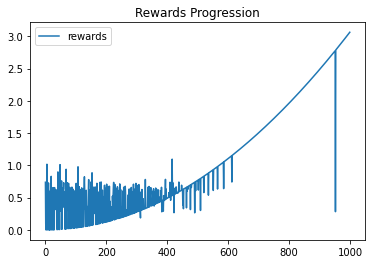

In [20]:
plt.plot([i for i in range(len(rewards))], rewards, label='rewards')
plt.legend()
plt.title('Rewards Progression')
plt.show()